# Simulating the Buckley-Leverette model

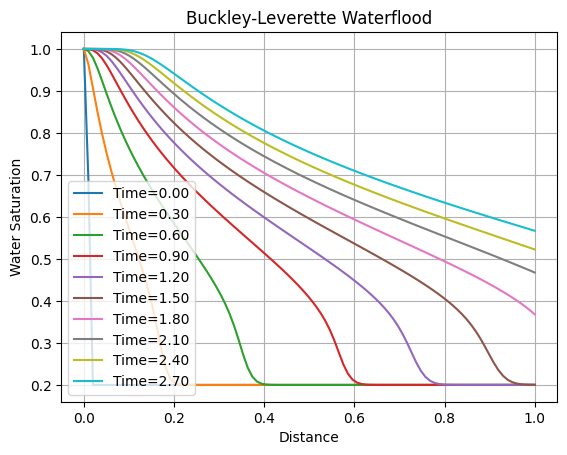

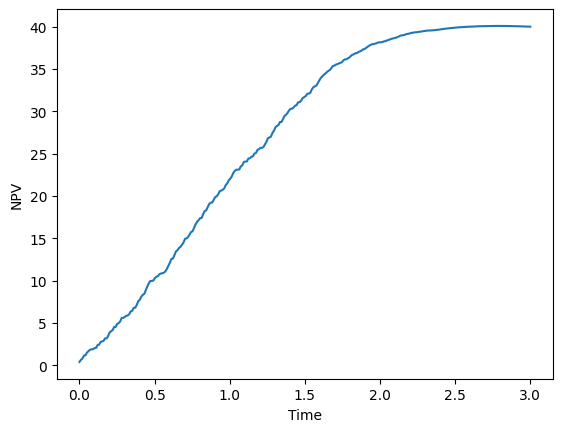

In [1]:
from buckley_leverette_ori import BuckleyLeverette 
import numpy as np

bl = BuckleyLeverette()

qt = 1.0 * np.random.rand(bl.nt)
# qt = np.ones(bl.nt) * 1.0
Sw = bl.Swinit.copy()

bl.simulate_w_plot(Sw, qt)

import matplotlib.pyplot as plt

npv = bl.cost_function(qt, Sw)

plt.plot(bl.t, npv)
plt.xlabel('Time')
plt.ylabel('NPV')
plt.show()
# bl.plot()

# Model Predictive Control


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9752
Number of nonzeros in inequality constraint Jacobian.:       99
Number of nonzeros in Lagrangian Hessian.............:     7426

Total number of variables............................:     2600
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2501
Total number of inequality c

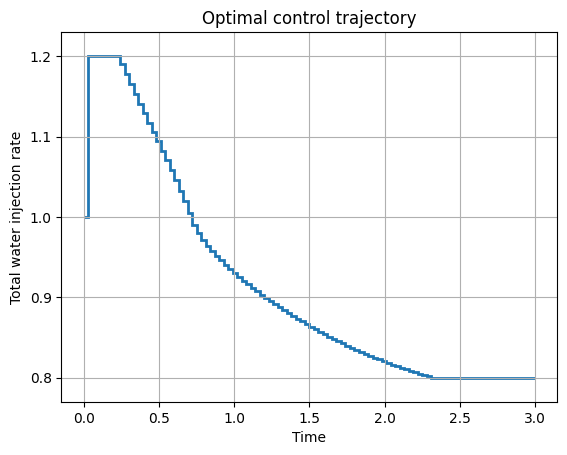

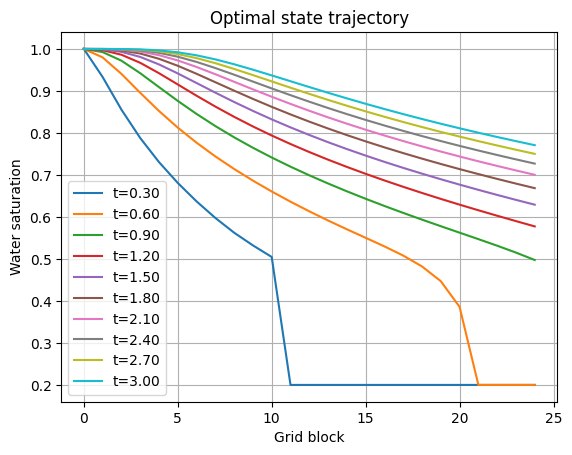

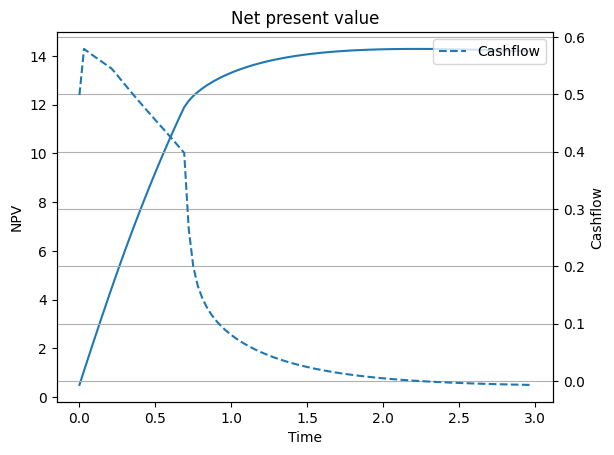

In [2]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from buckley_leverette import BuckleyLeverette 

from setup_bl import setup_bl_ocp, BLParamsMpc
from solver_ocp import SolverOcp

params_mpc = BLParamsMpc()
ocp = setup_bl_ocp(params_mpc)
solver = SolverOcp(ocp)


Sw0 = np.array([1.0]+[0.2]*(params_mpc.nx-1))  # initial state
qt = np.array([1.0]*params_mpc.N)  # initial guess for control

solver.set_initial_guess(Sw0, qt)
x_traj, u_traj = solver.solve(Sw0)

T = np.array(range(params_mpc.N+1))*params_mpc.dt

# plot control trajectory
plt.figure()
# plt.plot(T, u_traj.T)
plt.stairs(u_traj[0,:], T, label='u', baseline=None, orientation='vertical', linewidth=2)
plt.ylim(params_mpc.umin-0.03, params_mpc.umax+0.03)
plt.title('Optimal control trajectory')
plt.ylabel('Total water injection rate')
plt.xlabel('Time')
plt.grid(True)
plt.show()


# plot state trajectory
for k in range(x_traj.shape[1]):
    if k==0:
        plt.figure()
    elif k%10==0:
        plt.plot(range(params_mpc.nx), x_traj[:,k], label=f't={k*params_mpc.dt:.2f}')

plt.title('Optimal state trajectory')
plt.ylabel("Water saturation")
plt.xlabel("Grid block")
plt.grid(True)
plt.legend()
plt.show()

# plot the cost
cost_function = ca.Function('cost_function', [ocp.u, ocp.x], [ocp.stage_cost_expr])
cashflow = np.zeros(params_mpc.N)
npv = []
for k in range(params_mpc.N):
    if k==0:
        plt.figure()
    cashflow[k] = -cost_function(u_traj[0,k], x_traj[:,k])*0.99**(k)
    npv.append(cashflow[k] if k==0 else npv[-1] + cashflow[k])
        
plt.plot(T[:-1], npv, label='NPV')
plt.xlabel('Time')
plt.ylabel('NPV')
plt.title('Net present value')

# plot twin axis for cashflow
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.set_ylabel('Cashflow')
ax2.plot(T[:-1], cashflow, '--', label='Cashflow')

plt.legend()
plt.grid(True)
plt.show()
